In [1]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import cpa
import scanpy as sc
import os
import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
# print(os.environ["PATH"])

DATA_FILEPATH = "/media/ian/c3e3afd5-b309-47dc-a504-bad43c937410/Single Cell Pertubations"
CONTROL_GROUP = "Dimethyl Sulfoxide"
POSITIVE_CONTROL = ""

# https://www.kaggle.com/code/erotar/fork-of-nlp-regression-12a31a#Improving-Model
def add_columns(_data, _id_map):
    sm_name_to_smiles = _data.set_index('sm_name')['SMILES'].to_dict()
    sm_lincs_id = _data.set_index('sm_name')["sm_lincs_id"].to_dict()

    _id_map['SMILES'] = _id_map['sm_name'].map(sm_name_to_smiles)
    _id_map['sm_lincs_id'] = _id_map['sm_name'].map(sm_lincs_id)

    return _id_map

Global seed set to 0


In [2]:
de_train_df = pd.read_parquet(DATA_FILEPATH + "/de_train.parquet")
print("Differential Expression - train data")
print(de_train_df.shape)
display(de_train_df.head())

id_map = pd.read_csv(DATA_FILEPATH + "/id_map.csv")
print("ID Map")
print(id_map.shape)
print(id_map.columns)
display(id_map.head())

preds = pd.read_csv(DATA_FILEPATH + "/sample_submission.csv")
print("Sample Submission")
print(preds.shape)
print(preds.columns)
display(preds.head())

Differential Expression - train data
(614, 18216)


,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.104720,-0.077524,-1.625596,-0.144545,0.143555,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.915953,-0.884380,0.371834,-0.081677,-0.498266,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,T cells CD8+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,-0.387721,-0.305378,0.567777,0.303895,-0.022653,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,T regulatory cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.232893,0.129029,0.336897,0.486946,0.767661,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,NK cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,4.290652,-0.063864,-0.017443,-0.541154,0.570982,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629


ID Map
(255, 3)
Index(['id', 'cell_type', 'sm_name'], dtype='object')


,id,cell_type,sm_name
0,0,B cells,5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-...
1,1,B cells,ABT-199 (GDC-0199)
2,2,B cells,ABT737
3,3,B cells,AMD-070 (hydrochloride)
4,4,B cells,AT 7867


Sample Submission
(255, 18212)
Index(['id', 'A1BG', 'A1BG-AS1', 'A2M', 'A2M-AS1', 'A2MP1', 'A4GALT', 'AAAS',
       'AACS', 'AAGAB',
       ...
       'ZUP1', 'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11B',
       'ZYX', 'ZZEF1'],
      dtype='object', length=18212)


,id,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
de_train_Y = de_train_df.iloc[:, 5:]
display(de_train_Y)
de_train_X = de_train_df.iloc[:, 0:2]
display(de_train_X)
de_test_X = id_map.iloc[:, 1:3]
display(de_test_X)

train_X = pd.get_dummies(de_train_X, dtype=int)
test_X = pd.get_dummies(de_test_X, dtype=int)
print(train_X.shape)
print(test_X.shape)

# remove train data not seen in test, from https://www.kaggle.com/code/mehrankazeminia/3-op2-feature-augment-add-smiles-knn-svr
uncommon = [f for f in train_X if f not in test_X]
print(uncommon)

train_X = train_X.drop(columns=uncommon)
print(train_X.shape)
print(test_X.shape)
print(list(train_X.columns)==list(test_X.columns))

de_train_Y.to_csv("Y_train.csv", index=False)
train_X.to_csv("X_train.csv", index=False)
test_X.to_csv("X_test.csv", index=False)

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,0.104720,-0.077524,-1.625596,-0.144545,0.143555,0.073229,-0.016823,0.101717,-0.005153,1.043629,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,0.915953,-0.884380,0.371834,-0.081677,-0.498266,0.203559,0.604656,0.498592,-0.317184,0.375550,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,-0.387721,-0.305378,0.567777,0.303895,-0.022653,-0.480681,0.467144,-0.293205,-0.005098,0.214918,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,0.232893,0.129029,0.336897,0.486946,0.767661,0.718590,-0.162145,0.157206,-3.654218,-0.212402,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,4.290652,-0.063864,-0.017443,-0.541154,0.570982,2.022829,0.600011,1.231275,0.236739,0.338703,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,-0.014372,-0.122464,-0.456366,-0.147894,-0.545382,-0.544709,0.282458,-0.431359,-0.364961,0.043123,...,-0.549987,-2.200925,0.359806,1.073983,0.356939,-0.029603,-0.528817,0.105138,0.491015,-0.979951
610,-0.455549,0.188181,0.595734,-0.100299,0.786192,0.090954,0.169523,0.428297,0.106553,0.435088,...,-1.236905,0.003854,-0.197569,-0.175307,0.101391,1.028394,0.034144,-0.231642,1.023994,-0.064760
611,0.338168,-0.109079,0.270182,-0.436586,-0.069476,-0.061539,0.002818,-0.027167,-0.383696,0.226289,...,0.077579,-1.101637,0.457201,0.535184,-0.198404,-0.005004,0.552810,-0.209077,0.389751,-0.337082
612,0.101138,-0.409724,-0.606292,-0.071300,-0.001789,-0.706087,-0.620919,-1.485381,0.059303,-0.032584,...,0.005951,-0.893093,-1.003029,-0.080367,-0.076604,0.024849,0.012862,-0.029684,0.005506,-1.733112


,cell_type,sm_name
0,NK cells,Clotrimazole
1,T cells CD4+,Clotrimazole
2,T cells CD8+,Clotrimazole
3,T regulatory cells,Clotrimazole
4,NK cells,Mometasone Furoate
...,...,...
609,T regulatory cells,Atorvastatin
610,NK cells,Riociguat
611,T cells CD4+,Riociguat
612,T cells CD8+,Riociguat


,cell_type,sm_name
0,B cells,5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-...
1,B cells,ABT-199 (GDC-0199)
2,B cells,ABT737
3,B cells,AMD-070 (hydrochloride)
4,B cells,AT 7867
...,...,...
250,Myeloid cells,Vandetanib
251,Myeloid cells,Vanoxerine
252,Myeloid cells,Vardenafil
253,Myeloid cells,Vorinostat


(614, 152)
(255, 131)
['cell_type_NK cells', 'cell_type_T cells CD4+', 'cell_type_T cells CD8+', 'cell_type_T regulatory cells', 'sm_name_Alvocidib', 'sm_name_Belinostat', 'sm_name_CHIR-99021', 'sm_name_Crizotinib', 'sm_name_Dabrafenib', 'sm_name_Dactolisib', 'sm_name_Foretinib', 'sm_name_Idelalisib', 'sm_name_LDN 193189', 'sm_name_Linagliptin', 'sm_name_MLN 2238', 'sm_name_O-Demethylated Adapalene', 'sm_name_Oprozomib (ONX 0912)', 'sm_name_Palbociclib', 'sm_name_Penfluridol', 'sm_name_Porcn Inhibitor III', 'sm_name_R428']
(614, 131)
(255, 131)
True


In [4]:
de_cell_type = de_train_df.iloc[:, [0] + list(range(5, de_train_df.shape[1]))]
de_sm_name = de_train_df.iloc[:, [1] + list(range(5, de_train_df.shape[1]))]
de_cell_type.shape, de_sm_name.shape

mean_cell_type = de_cell_type.groupby('cell_type').mean().reset_index()
mean_sm_name = de_sm_name.groupby('sm_name').mean().reset_index()

display(mean_cell_type)
display(mean_sm_name)

rows = []

for name in de_cell_type['cell_type']:
    mean_rows = mean_cell_type[mean_cell_type['cell_type'] == name].copy()
    rows.append(mean_rows)

tr_cell_type = pd.concat(rows)
tr_cell_type = tr_cell_type.reset_index(drop=True)

rows = []
for name in de_sm_name['sm_name']:
    mean_rows = mean_sm_name[mean_sm_name['sm_name'] == name].copy()
    rows.append(mean_rows)

tr_sm_name = pd.concat(rows)
tr_sm_name = tr_sm_name.reset_index(drop=True)

display(tr_cell_type)
display(tr_sm_name)


rows = []
for name in id_map['cell_type']:
    mean_rows = mean_cell_type[mean_cell_type['cell_type'] == name].copy()
    rows.append(mean_rows)

te_cell_type = pd.concat(rows)
te_cell_type = te_cell_type.reset_index(drop=True)

rows = []
for name in id_map['sm_name']:
    mean_rows = mean_sm_name[mean_sm_name['sm_name'] == name].copy()
    rows.append(mean_rows)

te_sm_name = pd.concat(rows)
te_sm_name = te_sm_name.reset_index(drop=True)

display(te_cell_type)
display(te_sm_name)



,cell_type,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,B cells,1.380890,0.530585,1.340812,1.594307,4.927551,3.613191,0.028640,0.544636,0.723079,...,0.257778,0.674977,0.217386,1.439374,0.952903,0.581303,0.637408,0.517737,-0.207092,0.079199
1,Myeloid cells,1.570336,0.752564,-2.856826,0.887845,6.658911,4.034911,0.442943,0.403543,0.196285,...,-0.270423,-0.103318,-1.307952,-0.166312,1.883588,0.612681,-0.583563,-0.427938,-0.292768,-0.067723
2,NK cells,0.417735,0.409016,-0.224808,-0.425929,0.282997,1.324508,0.050034,0.405179,-0.065836,...,0.273242,-0.114225,0.019743,0.228173,0.226144,0.366789,0.205059,0.271480,-0.262843,-0.095723
3,T cells CD4+,0.020208,0.116092,0.107412,-0.327098,-0.034363,0.734447,-0.185652,0.279729,0.218412,...,-0.054699,0.262059,0.090887,0.173507,0.437869,0.169841,0.185947,0.084912,-0.144180,-0.037697
4,T cells CD8+,0.028166,-0.063453,0.019265,0.038879,0.138214,-0.090901,0.024953,0.086375,-0.220386,...,0.091154,-0.026132,-0.161742,0.080242,0.226675,0.061512,0.116773,-0.004632,-0.087825,-0.140895
5,T regulatory cells,0.733468,0.442569,0.898680,1.081128,1.145535,1.118455,0.058883,0.585039,-0.005645,...,-0.006385,0.480750,0.251817,0.495385,0.875552,0.873839,0.501520,0.315104,-0.125323,-0.030542


,sm_name,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-...,0.300267,-0.112432,0.413144,1.468632,0.733237,0.722462,0.125359,0.210903,-0.876761,...,-0.769578,-0.690020,0.303616,0.260685,0.555278,0.837875,0.444535,0.432414,-0.219858,0.551906
1,ABT-199 (GDC-0199),-0.081286,0.007314,0.081242,-0.125777,0.219469,0.258288,-0.160568,0.023898,0.317472,...,0.430786,0.094845,-0.088646,-0.140509,0.216322,-0.065943,0.113272,-0.181743,0.068095,-0.093228
2,ABT737,0.408012,0.322574,0.107448,-0.049174,0.422284,1.151523,0.751861,0.189453,-0.121147,...,0.186543,-0.180051,0.028183,0.413515,0.166978,0.327588,0.256550,-0.069630,-0.135967,-0.728025
3,AMD-070 (hydrochloride),-0.031131,0.533648,0.124738,0.241484,-0.017756,0.039647,-0.173965,0.806999,-0.019594,...,-0.100840,0.065319,0.193013,0.310814,0.018807,0.144418,0.000372,0.204476,-0.077820,0.166340
4,AT 7867,0.242736,-0.275840,0.158312,0.267365,-0.003346,0.183553,-0.228290,0.162294,-0.240859,...,-0.704684,-0.088803,-0.120544,-0.337481,0.051235,0.466585,-0.157225,0.622629,0.022401,0.079217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,Vandetanib,-0.006076,-0.672747,-0.230338,-0.492947,0.109427,-0.528983,0.030436,0.155058,-0.130232,...,0.113566,-0.056856,-0.375688,-0.098679,-0.203246,-0.313355,0.105695,-0.004788,0.135301,0.254045
142,Vanoxerine,0.188002,-0.459637,0.107419,0.442630,0.288657,0.239626,-0.191168,-0.257659,-0.149061,...,0.023219,-0.114899,0.148367,0.166318,0.220331,-0.095794,-0.191277,0.358461,-0.246971,-0.221379
143,Vardenafil,-0.097319,0.526795,-0.339189,-0.156595,0.021584,-0.269225,-0.216612,-0.447963,0.047921,...,0.044047,0.050485,0.528853,0.162957,0.079624,-0.091698,-0.154987,0.191808,0.325303,-0.385319
144,Vorinostat,0.075208,0.014575,0.454048,-0.009477,0.342563,-0.226654,0.517033,0.845815,1.743839,...,0.320819,0.542119,-0.402185,-0.104306,-0.586294,0.382534,-0.107183,0.212404,-0.029705,0.270488


,cell_type,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,0.417735,0.409016,-0.224808,-0.425929,0.282997,1.324508,0.050034,0.405179,-0.065836,...,0.273242,-0.114225,0.019743,0.228173,0.226144,0.366789,0.205059,0.271480,-0.262843,-0.095723
1,T cells CD4+,0.020208,0.116092,0.107412,-0.327098,-0.034363,0.734447,-0.185652,0.279729,0.218412,...,-0.054699,0.262059,0.090887,0.173507,0.437869,0.169841,0.185947,0.084912,-0.144180,-0.037697
2,T cells CD8+,0.028166,-0.063453,0.019265,0.038879,0.138214,-0.090901,0.024953,0.086375,-0.220386,...,0.091154,-0.026132,-0.161742,0.080242,0.226675,0.061512,0.116773,-0.004632,-0.087825,-0.140895
3,T regulatory cells,0.733468,0.442569,0.898680,1.081128,1.145535,1.118455,0.058883,0.585039,-0.005645,...,-0.006385,0.480750,0.251817,0.495385,0.875552,0.873839,0.501520,0.315104,-0.125323,-0.030542
4,NK cells,0.417735,0.409016,-0.224808,-0.425929,0.282997,1.324508,0.050034,0.405179,-0.065836,...,0.273242,-0.114225,0.019743,0.228173,0.226144,0.366789,0.205059,0.271480,-0.262843,-0.095723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,T regulatory cells,0.733468,0.442569,0.898680,1.081128,1.145535,1.118455,0.058883,0.585039,-0.005645,...,-0.006385,0.480750,0.251817,0.495385,0.875552,0.873839,0.501520,0.315104,-0.125323,-0.030542
610,NK cells,0.417735,0.409016,-0.224808,-0.425929,0.282997,1.324508,0.050034,0.405179,-0.065836,...,0.273242,-0.114225,0.019743,0.228173,0.226144,0.366789,0.205059,0.271480,-0.262843,-0.095723
611,T cells CD4+,0.020208,0.116092,0.107412,-0.327098,-0.034363,0.734447,-0.185652,0.279729,0.218412,...,-0.054699,0.262059,0.090887,0.173507,0.437869,0.169841,0.185947,0.084912,-0.144180,-0.037697
612,T cells CD8+,0.028166,-0.063453,0.019265,0.038879,0.138214,-0.090901,0.024953,0.086375,-0.220386,...,0.091154,-0.026132,-0.161742,0.080242,0.226675,0.061512,0.116773,-0.004632,-0.087825,-0.140895


,sm_name,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,Clotrimazole,0.216461,-0.284563,-0.087272,0.141155,0.097574,0.128674,0.223208,0.116077,-0.995413,...,-0.097627,0.089216,0.035855,0.105090,-0.114809,-0.417534,-0.044722,0.276610,0.403164,-0.211380
1,Clotrimazole,0.216461,-0.284563,-0.087272,0.141155,0.097574,0.128674,0.223208,0.116077,-0.995413,...,-0.097627,0.089216,0.035855,0.105090,-0.114809,-0.417534,-0.044722,0.276610,0.403164,-0.211380
2,Clotrimazole,0.216461,-0.284563,-0.087272,0.141155,0.097574,0.128674,0.223208,0.116077,-0.995413,...,-0.097627,0.089216,0.035855,0.105090,-0.114809,-0.417534,-0.044722,0.276610,0.403164,-0.211380
3,Clotrimazole,0.216461,-0.284563,-0.087272,0.141155,0.097574,0.128674,0.223208,0.116077,-0.995413,...,-0.097627,0.089216,0.035855,0.105090,-0.114809,-0.417534,-0.044722,0.276610,0.403164,-0.211380
4,Mometasone Furoate,1.330514,0.089259,0.925070,1.059381,0.503060,0.996421,-0.006012,1.318401,0.011984,...,-0.157324,0.386411,0.330060,0.204926,0.231450,0.475624,0.274146,0.057875,-1.131550,0.613541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,Atorvastatin,0.280193,-0.105356,0.014759,0.052414,-0.274411,-0.044712,-0.373036,0.113470,-0.321457,...,-0.198790,-0.143693,0.355118,-0.312425,0.264163,0.189755,-0.069407,0.077091,0.013840,-0.610520
610,Riociguat,-0.193340,-0.061178,-0.117600,-0.493997,0.004746,-0.350414,-0.081786,-0.467478,-0.114670,...,-0.230258,-1.059673,-0.272358,-0.160014,-0.326247,0.231997,0.133820,-0.268421,0.330302,-0.721409
611,Riociguat,-0.193340,-0.061178,-0.117600,-0.493997,0.004746,-0.350414,-0.081786,-0.467478,-0.114670,...,-0.230258,-1.059673,-0.272358,-0.160014,-0.326247,0.231997,0.133820,-0.268421,0.330302,-0.721409
612,Riociguat,-0.193340,-0.061178,-0.117600,-0.493997,0.004746,-0.350414,-0.081786,-0.467478,-0.114670,...,-0.230258,-1.059673,-0.272358,-0.160014,-0.326247,0.231997,0.133820,-0.268421,0.330302,-0.721409


,cell_type,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,B cells,1.380890,0.530585,1.340812,1.594307,4.927551,3.613191,0.028640,0.544636,0.723079,...,0.257778,0.674977,0.217386,1.439374,0.952903,0.581303,0.637408,0.517737,-0.207092,0.079199
1,B cells,1.380890,0.530585,1.340812,1.594307,4.927551,3.613191,0.028640,0.544636,0.723079,...,0.257778,0.674977,0.217386,1.439374,0.952903,0.581303,0.637408,0.517737,-0.207092,0.079199
2,B cells,1.380890,0.530585,1.340812,1.594307,4.927551,3.613191,0.028640,0.544636,0.723079,...,0.257778,0.674977,0.217386,1.439374,0.952903,0.581303,0.637408,0.517737,-0.207092,0.079199
3,B cells,1.380890,0.530585,1.340812,1.594307,4.927551,3.613191,0.028640,0.544636,0.723079,...,0.257778,0.674977,0.217386,1.439374,0.952903,0.581303,0.637408,0.517737,-0.207092,0.079199
4,B cells,1.380890,0.530585,1.340812,1.594307,4.927551,3.613191,0.028640,0.544636,0.723079,...,0.257778,0.674977,0.217386,1.439374,0.952903,0.581303,0.637408,0.517737,-0.207092,0.079199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,Myeloid cells,1.570336,0.752564,-2.856826,0.887845,6.658911,4.034911,0.442943,0.403543,0.196285,...,-0.270423,-0.103318,-1.307952,-0.166312,1.883588,0.612681,-0.583563,-0.427938,-0.292768,-0.067723
251,Myeloid cells,1.570336,0.752564,-2.856826,0.887845,6.658911,4.034911,0.442943,0.403543,0.196285,...,-0.270423,-0.103318,-1.307952,-0.166312,1.883588,0.612681,-0.583563,-0.427938,-0.292768,-0.067723
252,Myeloid cells,1.570336,0.752564,-2.856826,0.887845,6.658911,4.034911,0.442943,0.403543,0.196285,...,-0.270423,-0.103318,-1.307952,-0.166312,1.883588,0.612681,-0.583563,-0.427938,-0.292768,-0.067723
253,Myeloid cells,1.570336,0.752564,-2.856826,0.887845,6.658911,4.034911,0.442943,0.403543,0.196285,...,-0.270423,-0.103318,-1.307952,-0.166312,1.883588,0.612681,-0.583563,-0.427938,-0.292768,-0.067723


,sm_name,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-...,0.300267,-0.112432,0.413144,1.468632,0.733237,0.722462,0.125359,0.210903,-0.876761,...,-0.769578,-0.690020,0.303616,0.260685,0.555278,0.837875,0.444535,0.432414,-0.219858,0.551906
1,ABT-199 (GDC-0199),-0.081286,0.007314,0.081242,-0.125777,0.219469,0.258288,-0.160568,0.023898,0.317472,...,0.430786,0.094845,-0.088646,-0.140509,0.216322,-0.065943,0.113272,-0.181743,0.068095,-0.093228
2,ABT737,0.408012,0.322574,0.107448,-0.049174,0.422284,1.151523,0.751861,0.189453,-0.121147,...,0.186543,-0.180051,0.028183,0.413515,0.166978,0.327588,0.256550,-0.069630,-0.135967,-0.728025
3,AMD-070 (hydrochloride),-0.031131,0.533648,0.124738,0.241484,-0.017756,0.039647,-0.173965,0.806999,-0.019594,...,-0.100840,0.065319,0.193013,0.310814,0.018807,0.144418,0.000372,0.204476,-0.077820,0.166340
4,AT 7867,0.242736,-0.275840,0.158312,0.267365,-0.003346,0.183553,-0.228290,0.162294,-0.240859,...,-0.704684,-0.088803,-0.120544,-0.337481,0.051235,0.466585,-0.157225,0.622629,0.022401,0.079217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,Vandetanib,-0.006076,-0.672747,-0.230338,-0.492947,0.109427,-0.528983,0.030436,0.155058,-0.130232,...,0.113566,-0.056856,-0.375688,-0.098679,-0.203246,-0.313355,0.105695,-0.004788,0.135301,0.254045
251,Vanoxerine,0.188002,-0.459637,0.107419,0.442630,0.288657,0.239626,-0.191168,-0.257659,-0.149061,...,0.023219,-0.114899,0.148367,0.166318,0.220331,-0.095794,-0.191277,0.358461,-0.246971,-0.221379
252,Vardenafil,-0.097319,0.526795,-0.339189,-0.156595,0.021584,-0.269225,-0.216612,-0.447963,0.047921,...,0.044047,0.050485,0.528853,0.162957,0.079624,-0.091698,-0.154987,0.191808,0.325303,-0.385319
253,Vorinostat,0.075208,0.014575,0.454048,-0.009477,0.342563,-0.226654,0.517033,0.845815,1.743839,...,0.320819,0.542119,-0.402185,-0.104306,-0.586294,0.382534,-0.107183,0.212404,-0.029705,0.270488


In [5]:
# https://www.kaggle.com/code/erotar/fork-of-nlp-regression-12a31a#Improving-Model
id_map_SMILES = add_columns(de_train_df, id_map)

cell_type_feature = pd.DataFrame(de_train_df["cell_type"], columns=["cell_type"])
smiles_feature = pd.DataFrame(de_train_df["SMILES"], columns=["SMILES"])
labels = de_train_df.drop(["cell_type","sm_name","sm_lincs_id","SMILES","control"], axis=1)

# for test
test_feature_smiles = pd.DataFrame(id_map["SMILES"], columns=["SMILES"])
test_feature_cell_type = pd.DataFrame(id_map["cell_type"], columns=["cell_type"])

# Normalize labels
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
norm_label = scaler.fit_transform(labels)


# Onehotencode
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
one_hot_celltype = encoder.fit_transform(cell_type_feature)
one_hot_test_cell_type = encoder.transform(test_feature_cell_type)

# Function to split sentences into characters
def split_chars(text):
    return " ".join(list(text))

full_smiles = smiles_feature["SMILES"].values 
full_cell_type = one_hot_celltype.toarray()
full_labels = norm_label

final_test_smiles = test_feature_smiles["SMILES"].values
final_cell_type = one_hot_test_cell_type.toarray()

# For final training
full_train_smiles = [split_chars(feature) for feature in full_smiles]
final_test_smiles = [split_chars(feature) for feature in final_test_smiles]

# What's the average character length?
char_len_smiles = [len(feature) for feature in full_smiles]
mean_char_smiles = np.mean(char_len_smiles)
max_char_smiles = np.max(char_len_smiles)

#  Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_len_smiles, 95))

unique_characters = []

# Iterate over the "features" and extract unique characters
for feature in full_train_smiles:
    unique_characters.extend(set(feature))

# Remove duplicates by converting the list to a set and then back to a list
unique_characters = list(set(unique_characters))

# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(unique_characters) + 2


In [6]:
smiles_rename_dict = dict(zip(full_smiles, full_train_smiles))
de_train_df["SMILES"] = de_train_df["SMILES"].replace(smiles_rename_dict)
de_train_df.head()

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,Clotrimazole,LSM-5341,C l c 1 c c c c c 1 C ( c 1 c c c c c 1 ) ( c ...,False,0.104720,-0.077524,-1.625596,-0.144545,0.143555,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,T cells CD4+,Clotrimazole,LSM-5341,C l c 1 c c c c c 1 C ( c 1 c c c c c 1 ) ( c ...,False,0.915953,-0.884380,0.371834,-0.081677,-0.498266,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,T cells CD8+,Clotrimazole,LSM-5341,C l c 1 c c c c c 1 C ( c 1 c c c c c 1 ) ( c ...,False,-0.387721,-0.305378,0.567777,0.303895,-0.022653,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,T regulatory cells,Clotrimazole,LSM-5341,C l c 1 c c c c c 1 C ( c 1 c c c c c 1 ) ( c ...,False,0.232893,0.129029,0.336897,0.486946,0.767661,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,NK cells,Mometasone Furoate,LSM-3349,C [ C @ @ H ] 1 C [ C @ H ] 2 [ C @ @ H ] 3 C ...,False,4.290652,-0.063864,-0.017443,-0.541154,0.570982,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629


In [7]:
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_iter = iter(de_train_df["SMILES"])

vocab = build_vocab_from_iterator(train_iter)

tokenizer = get_tokenizer(None)

MAX_TOKEN_LENGTH = output_seq_char_len

# https://stackoverflow.com/questions/55041080/how-does-pytorch-dataloader-handle-variable-size-data
def pad_sequence(seq):
    def _pad(_it, _max_len):
        return _it + [0] * (_max_len - len(_it)) 
    return _pad(seq, MAX_TOKEN_LENGTH)


def collate_batch(batch):
    text_list, offsets = [], [0]
    for _text in batch:
        processed_text = [vocab[token] for token in tokenizer(_text)]
        if len(processed_text) < MAX_TOKEN_LENGTH:
            processed_text = pad_sequence(processed_text)
        # if processed text is less than max_token length: pad with 0's
        elif len(processed_text) > MAX_TOKEN_LENGTH:
            processed_text = processed_text[:MAX_TOKEN_LENGTH]
        # elif processed test is greated than max token length: truncate
        assert len(processed_text) == MAX_TOKEN_LENGTH
        processed_text = torch.tensor(processed_text, dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return text_list.to(device), offsets.to(device)


dataloader = DataLoader(
    de_train_df["SMILES"], batch_size=1, collate_fn=collate_batch
)

vocab_size = len(vocab)
EMBEDDING_SIZE = 16

_embedding = torch.nn.Embedding(vocab_size, EMBEDDING_SIZE, sparse=False).to(device)
initrange = 0.5
_embedding.weight.data.uniform_(-initrange, initrange)

data = [torch.tensor([vocab[token] for token in tokenizer(item)], dtype=torch.long) for item in de_train_df["SMILES"]]

_embeddings = []
n=0

for idx, (text, offsets) in enumerate(dataloader):
    _embed = _embedding(text)
    _embeddings.append(_embed)
    n+= 1

614lines [00:00, 262598.42lines/s]


In [8]:
display(len(_embeddings))
display(_embeddings[0].size())

_flattenedInputEmbeddings = []
for _embed in _embeddings:
    _flattenedInputEmbeddings.append(torch.flatten(_embed))

display(_flattenedInputEmbeddings[0].size())

614

torch.Size([97, 16])

torch.Size([1552])

In [9]:
dataloader = DataLoader(
    final_test_smiles, batch_size=1, collate_fn=collate_batch
)

_testEmbeddings = []
n=0

for idx, (text, offsets) in enumerate(dataloader):
    _embed = _embedding(text)
    _testEmbeddings.append(_embed)
    n+= 1

_flattenedTestEmbeddings = []
for _embed in _testEmbeddings:
    _flattenedTestEmbeddings.append(torch.flatten(_embed))

In [10]:
_cellTypes = torch.tensor(train_X.values, dtype=torch.float32).to(device)
_smileEmbeddings = torch.stack(_flattenedInputEmbeddings)
_embeddingInput = torch.cat((_cellTypes, _smileEmbeddings), dim=1)

_output = torch.tensor(de_train_Y.values, dtype=torch.float32).to(device)

_testEmbeddingInput = torch.stack(_flattenedTestEmbeddings)
_testCellTypes = torch.tensor(test_X.values, dtype=torch.float32).to(device)
_testInput = torch.cat((_testCellTypes, _testEmbeddingInput), dim=1).detach()

In [11]:
from sklearn.model_selection import train_test_split

train_idx, valid_idx= train_test_split(
    np.arange(len(_output)), test_size=0.2, random_state=42, shuffle=True)

_embeddingInputTrain = _embeddingInput[train_idx].to(device)
_embeddingInputVal = _embeddingInput[valid_idx].to(device).detach()
_outputTrain = _output[train_idx].to(device)
_outputVal = _output[valid_idx].to(device).detach()


In [12]:
display(_embeddingInputTrain.size())
display(_embeddingInputVal.size())
display(_testInput.size())

torch.Size([491, 1683])

torch.Size([123, 1683])

torch.Size([255, 1683])

In [13]:
from torch.nn import BatchNorm1d as BatchNormalization
from torch.nn import Linear
from torch.nn import Dropout
from torch.nn import ReLU
from torch.nn import ELU
import matplotlib.pyplot as plt

INPUT_NEURONS = _embeddingInput.size()[1]
OUTPUT_NEURONS = _output.size()[1]

_torch_embed_Model = torch.nn.Sequential(
    Linear(INPUT_NEURONS, 512),
    BatchNormalization(512),
    ELU(),
    Dropout(0.1),
    Linear(512, 256),
    BatchNormalization(256),
    ELU(),
    Dropout(0.3),
    Linear(256, 128),
    ELU(),
    Dropout(0.2),
    Linear(128, 256),
    ELU(),
    BatchNormalization(256),
    Dropout(0.2),
    Linear(256, 512),
    ELU(),
    Dropout(0.05),
    Linear(512, OUTPUT_NEURONS)
).to(device)

In [14]:
def mrrmse_torch(y_true: torch.tensor, y_pred: torch.tensor):
    return torch.mean(torch.sqrt(torch.mean(torch.square(y_true - y_pred), axis=1)))

In [15]:
loss_fn = torch.nn.HuberLoss()
optimizer = torch.optim.Adam(_torch_embed_Model.parameters(), lr=0.01)

n_epochs = 200   # number of epochs to run
trainL1LossList = []
valL1LossList = []
trainMRRMSELossList = []
valMRRMSELossList = []

n = 0

for epoch in range(n_epochs):
    n += 1

    _torch_embed_Model.train()
    

    _preds = _torch_embed_Model(_embeddingInputTrain)
    _loss = loss_fn(_preds, _outputTrain)
    optimizer.zero_grad()

    _loss.backward(retain_graph=True)

    _trainLoss = mrrmse_torch(_preds, _outputTrain)
    trainMRRMSELossList.append(_trainLoss.cpu().detach().numpy())


    _valPreds = _torch_embed_Model(_embeddingInputVal)
    _valLoss = mrrmse_torch(_valPreds, _outputVal)
    valMRRMSELossList.append(_valLoss.cpu().detach().numpy())
    

    optimizer.step()

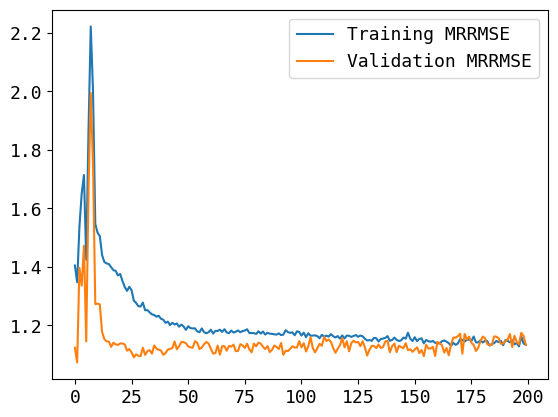

In [16]:
plt.plot(list(range(n_epochs)), trainMRRMSELossList, label="Training MRRMSE")
plt.plot(list(range(n_epochs)), valMRRMSELossList, label="Validation MRRMSE")
plt.legend()
plt.show()

In [17]:
n_epochs = 200   # number of epochs to run

trainMRRMSELossList = []

n = 0

for epoch in range(n_epochs):
    n += 1

    _torch_embed_Model.train()

    _preds = _torch_embed_Model(_embeddingInput)
    _loss = loss_fn(_preds, _output)
    optimizer.zero_grad()

    _loss.backward(retain_graph=True)

    _trainLoss = mrrmse_torch(_preds, _output)
    trainMRRMSELossList.append(_trainLoss.cpu().detach().numpy())

    optimizer.step()

_testPreds = _torch_embed_Model(_testInput)

In [18]:
_preds = pd.DataFrame(_testPreds.cpu().detach().numpy(), columns=de_train_Y.columns)
_preds.index.names = ["id"]
_preds.shape

(255, 18211)

In [34]:
_preds1 = _torch_embed_Model(_embeddingInput)
_preds1

tensor([[ 0.2176,  0.0234,  0.2327,  ...,  0.2695,  0.0971, -0.1954],
        [ 0.1337, -0.0466,  0.2761,  ...,  0.1469,  0.0654, -0.1788],
        [ 0.1176, -0.0045,  0.2706,  ...,  0.1419,  0.0352, -0.2531],
        ...,
        [-0.1454,  0.1826, -0.0688,  ...,  0.0591,  0.0564, -0.1835],
        [-0.1146,  0.2342, -0.2349,  ...,  0.1148, -0.0124,  0.0124],
        [-0.0686,  0.1730, -0.0860,  ..., -0.0511,  0.0324, -0.2227]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [35]:
_output

tensor([[ 0.1047, -0.0775, -1.6256,  ...,  0.0341,  0.2214,  0.3688],
        [ 0.9160, -0.8844,  0.3718,  ...,  0.7048,  1.0967, -0.8699],
        [-0.3877, -0.3054,  0.5678,  ...,  0.4158,  0.0784, -0.2594],
        ...,
        [ 0.3382, -0.1091,  0.2702,  ..., -0.2091,  0.3898, -0.3371],
        [ 0.1011, -0.4097, -0.6063,  ..., -0.0297,  0.0055, -1.7331],
        [-0.7571,  0.0859, -0.7300,  ..., -0.6033, -0.0980, -0.7507]],
       device='cuda:0')

In [36]:
torch.abs(_output - _preds1)

tensor([[0.1129, 0.1009, 1.8583,  ..., 0.2354, 0.1243, 0.5642],
        [0.7822, 0.8378, 0.0957,  ..., 0.5579, 1.0313, 0.6911],
        [0.5053, 0.3009, 0.2972,  ..., 0.2739, 0.0432, 0.0063],
        ...,
        [0.4836, 0.2917, 0.3390,  ..., 0.2682, 0.3334, 0.1536],
        [0.2158, 0.6440, 0.3714,  ..., 0.1445, 0.0179, 1.7455],
        [0.6885, 0.0871, 0.6441,  ..., 0.5521, 0.1305, 0.5280]],
       device='cuda:0', grad_fn=<AbsBackward0>)

In [38]:
std_order = (_preds.std()).sort_values(ascending=False).index
_tickLabels = de_train_Y.columns

orderList = std_order.values.tolist()
ogList = de_train_Y.columns
range_idx = [ogList.tolist().index(i) for i in orderList]

_tickSortedRange = _tickLabels[range_idx]

In [44]:
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.colors import n_colors
from plotly.subplots import make_subplots

_trainPreds = _torch_embed_Model(_embeddingInput)
_MAEloss = torch.abs(_output - _trainPreds)

# N = random.randrange(de_train_Y.shape[1])
N = 10

group_labels = ['FFNN Predictions', 'Ground Truth']

colors = n_colors('rgb(5, 200, 200)', 'rgb(200, 10, 10)', N, colortype='rgb')

fig = make_subplots(rows=N, cols=1)
i = 1

for data_line, label, color in zip(de_train_Y[std_order].T.values[:N], _tickSortedRange[:N], colors):
    print(':' *40)
    print('Column number :', i)
    print('Column name :', list(de_train_Y[std_order].columns)[i])
    print(':' *40)
    hist_data = [_preds[std_order].iloc[:, i], de_train_Y[std_order].iloc[:, i]]
    fig2 = ff.create_distplot(hist_data, group_labels, bin_size=.2, show_hist=False, show_rug=False)
    for _trace in fig2.select_traces():
        fig.add_trace(_trace, row=i, col=1)
    i += 1

fig.write_image("EnsembledPrediction.jpg")
fig.show(renderer='notebook_connected')

::::::::::::::::::::::::::::::::::::::::
Column number : 1
Column name : UFC1
::::::::::::::::::::::::::::::::::::::::
::::::::::::::::::::::::::::::::::::::::
Column number : 2
Column name : STMN1
::::::::::::::::::::::::::::::::::::::::
::::::::::::::::::::::::::::::::::::::::
Column number : 3
Column name : GTF3C6
::::::::::::::::::::::::::::::::::::::::
::::::::::::::::::::::::::::::::::::::::
Column number : 4
Column name : H2AFJ
::::::::::::::::::::::::::::::::::::::::
::::::::::::::::::::::::::::::::::::::::
Column number : 5
Column name : HIST1H1C
::::::::::::::::::::::::::::::::::::::::
::::::::::::::::::::::::::::::::::::::::
Column number : 6
Column name : H1FX
::::::::::::::::::::::::::::::::::::::::
::::::::::::::::::::::::::::::::::::::::
Column number : 7
Column name : HMGN2
::::::::::::::::::::::::::::::::::::::::
::::::::::::::::::::::::::::::::::::::::
Column number : 8
Column name : RPS18
::::::::::::::::::::::::::::::::::::::::
::::::::::::::::::::::::::::::::::::::

In [49]:
_trainPreds = _torch_embed_Model(_embeddingInput)
_MAEloss = pd.DataFrame(torch.abs(_output - _trainPreds).cpu().detach().numpy(), columns=de_train_Y.columns)

mae_order = _MAEloss.sum().sort_values(ascending=False).index
_tickLabels = de_train_Y.columns

orderList = mae_order.values.tolist()
ogList = de_train_Y.columns
range_idx = [ogList.tolist().index(i) for i in orderList]

_tickSortedRange = _tickLabels[range_idx]

In [48]:
_MAEloss.sum()

A1BG        403.470001
A1BG-AS1    379.300537
A2M         456.218384
A2M-AS1     524.141052
A2MP1       524.698608
               ...    
ZXDB        359.680878
ZXDC        305.577332
ZYG11B      293.364441
ZYX         323.848145
ZZEF1       309.833618
Length: 18211, dtype: float32

In [50]:
# N = random.randrange(de_train_Y.shape[1])
N = 10

group_labels = ['FFNN Predictions', 'Ground Truth']

colors = n_colors('rgb(5, 200, 200)', 'rgb(200, 10, 10)', N, colortype='rgb')

fig = make_subplots(rows=N, cols=1)
i = 1

for data_line, label, color in zip(de_train_Y[mae_order].T.values[:N], _tickSortedRange[:N], colors):
    print(':' *40)
    print('Column number :', i)
    print('Column name :', list(de_train_Y[mae_order].columns)[i])
    print(':' *40)
    hist_data = [_preds[mae_order].iloc[:, i], de_train_Y[mae_order].iloc[:, i]]
    fig2 = ff.create_distplot(hist_data, group_labels, bin_size=.2, show_hist=False, show_rug=False)
    for _trace in fig2.select_traces():
        fig.add_trace(_trace, row=i, col=1)
    i += 1

fig.write_image("EnsembledPrediction.jpg")
fig.show(renderer='notebook_connected')

::::::::::::::::::::::::::::::::::::::::
Column number : 1
Column name : HSP90AA1
::::::::::::::::::::::::::::::::::::::::
::::::::::::::::::::::::::::::::::::::::
Column number : 2
Column name : HCST
::::::::::::::::::::::::::::::::::::::::
::::::::::::::::::::::::::::::::::::::::
Column number : 3
Column name : BAX
::::::::::::::::::::::::::::::::::::::::
::::::::::::::::::::::::::::::::::::::::
Column number : 4
Column name : ZFAS1
::::::::::::::::::::::::::::::::::::::::
::::::::::::::::::::::::::::::::::::::::
Column number : 5
Column name : RPS27L
::::::::::::::::::::::::::::::::::::::::
::::::::::::::::::::::::::::::::::::::::
Column number : 6
Column name : ACTB
::::::::::::::::::::::::::::::::::::::::
::::::::::::::::::::::::::::::::::::::::
Column number : 7
Column name : CORO1A
::::::::::::::::::::::::::::::::::::::::
::::::::::::::::::::::::::::::::::::::::
Column number : 8
Column name : TMSB4X
::::::::::::::::::::::::::::::::::::::::
::::::::::::::::::::::::::::::::::::::

In [44]:
_preds.to_csv(DATA_FILEPATH + "/IPH_prediction_v12.csv")